<a href="https://colab.research.google.com/github/AnnaFejes/AirlinePricing/blob/main/AirlinePricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Airline Pricing
Step by step analysis on how the days to assess how the number of days between booking a flight and travelling affects pricing.

### Importing Data & Cleaning

In [1]:
#Importing Packages
!pip install pycaret
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycaret
import plotly.express as px
import datetime
from sklearn.preprocessing import LabelEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 54.6 MB/s eta 0:

In [2]:
#Importing File
#File is also available in the Github repository as a .zip file
from google.colab import drive
#drive.mount('/content/drive')
file_id = '1sUftnUHed_OPyFBczWRlZEQwbL-xPNhK'
link = f'https://drive.google.com/uc?id={file_id}'
flightdata = pd.read_csv(link)

In [3]:
#Data Cleansing
#Certain columns (Airline-Class, Departure Time, Arrival Time) are containing more than one datapoints, split by a newline character.
#In this step the columns mentioned above are split to the various datapoints.
flightdata[['Airline','Flight','Class']] = flightdata['Airline-Class'].str.split('\n',expand=True)
flightdata[['DepartureTime', 'DepartureAirport']] = flightdata['Departure Time'].str.split('\n', expand=True)
flightdata[['ArrivalTime', 'ArrivalAirport']] = flightdata['Arrival Time'].str.split('\n', expand=True)
#Added a date difference between Booking and Journey Dates, as all the data was collected on the same day.
flightdata['Date of Booking'] = pd.to_datetime(flightdata['Date of Booking'], dayfirst=True)
flightdata['Date of Journey'] = pd.to_datetime(flightdata['Date of Journey'], dayfirst=True)
flightdata['DaysToTravel'] = flightdata.apply(lambda row: (row['Date of Journey'] - row['Date of Booking']).days, axis=1)
#Transforming the Duration into minutes, so that it can be used as a determiner of the length of the flight
flightdata['Duration'] =  flightdata['Duration'].str.replace('h ','').str.replace('m','')
flightdata['h'], flightdata['m'] = flightdata['Duration'].str[:2].astype(int), flightdata['Duration'].str[2:].astype(int)
flightdata['FlightDuration'] = flightdata['h']*60 + flightdata['m']
#Adding an identifier to length of flight. Here the very basic short/medium/long haul definitions are used.
HaulLengthConditions = [
    (flightdata['FlightDuration'] < 180),
    (flightdata['FlightDuration'] >= 180) & (flightdata['FlightDuration'] < 360),
    (flightdata['FlightDuration'] >= 360)
    ]
HaulLengthLabels = ['Short Haul', 'Medium Haul', 'Long Haul']
flightdata['Haul'] = np.select(HaulLengthConditions, HaulLengthLabels)
#Convert the values in Price column to integer
flightdata['Price'] =  flightdata['Price'].str.replace(',','').astype(int)
#And finally cleared up all the unnecessary columns
flightdata = flightdata.drop(columns = ['Date of Booking', 'Airline-Class', 'Departure Time', 'Arrival Time', 'Duration', 'h', 'm'])
#And last but not least, renaming and reordering the columns - this is purely for me as I like them in order
flightdata = flightdata.rename(columns={"Date of Journey": "JourneyDate", "FlightDuration": "Duration", "Total Stops": "Stops"})
flightdata = flightdata.sort_values(by=['DaysToTravel'])
flightdata = flightdata.reindex(['JourneyDate','DaysToTravel','Airline', 'Flight', 'Class', 'DepartureAirport',
                                 'ArrivalAirport', 'DepartureTime', 'ArrivalTime', 'Duration', 'Haul', 'Stops', 'Price'], axis=1)


### Exploratory Analysis

In [4]:
#Initial line graph for exploratory analysis - for this it is best to break down by cabin
ec = flightdata[flightdata['Class'] == "ECONOMY"] #economy cabin
pe = flightdata[flightdata['Class'] == "PREMIUMECONOMY"] #premium economy cabin
bu = flightdata[flightdata['Class'] == "BUSINESS"] #business cabin
fi = flightdata[flightdata['Class'] == "FIRST"] #first cabin
#Let's determine the averages by date and by cabin
ecbydate = ec.groupby('JourneyDate').agg({'Price': 'mean'})
ecbydate = ecbydate.reset_index()
pebydate = pe.groupby('JourneyDate').agg({'Price': 'mean'})
pebydate = pebydate.reset_index()
bubydate = bu.groupby('JourneyDate').agg({'Price': 'mean'})
bubydate = bubydate.reset_index()
fibydate = fi.groupby('JourneyDate').agg({'Price': 'mean'})
fibydate = fibydate.reset_index()

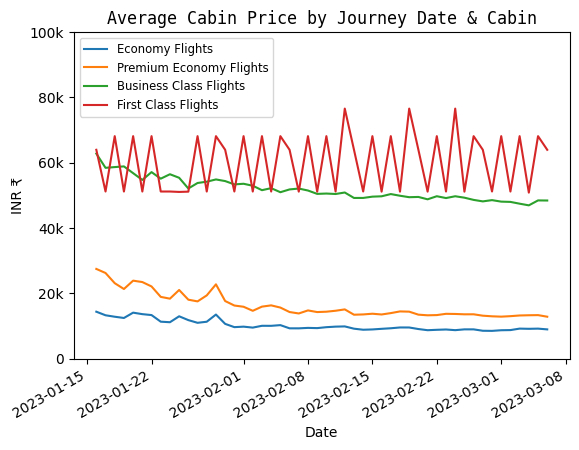

In [5]:
#Initial line graph for exploratory analysis - plotting them all on a graph
plt.plot(ecbydate['JourneyDate'], ecbydate['Price'], label = "Economy Flights")
plt.plot(pebydate['JourneyDate'], pebydate['Price'], label = "Premium Economy Flights")
plt.plot(bubydate['JourneyDate'], bubydate['Price'], label = "Business Class Flights")
plt.plot(fibydate['JourneyDate'], fibydate['Price'], label = "First Class Flights")
plt.title('Average Cabin Price by Journey Date & Cabin', fontfamily='monospace')
plt.xlabel('Date')
plt.ylabel('INR ₹')
plt.yticks(np.arange(0, 100001, 20000), labels=('0', '20k', '40k', '60k', '80k', '100k')) #formatting the labels on the y axis
plt.gcf().autofmt_xdate() #to format the dates so they are all visible and not overlapping
plt.legend(loc = 'upper left', fontsize = 'small') #to show the legend, it is formatted in a way that it does not hide any datapoints
plt.show()

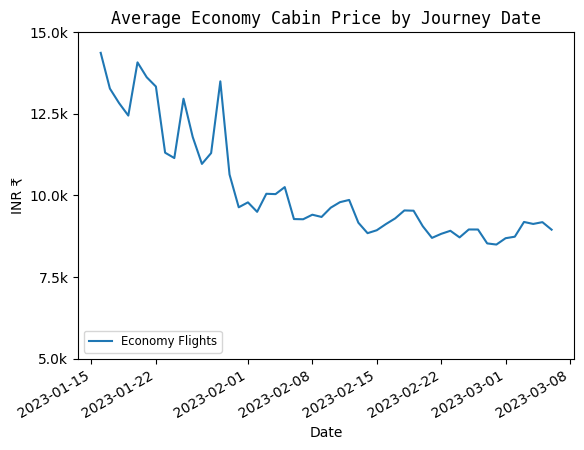

In [ ]:
#Initial line graph for exploratory analysis - plotting economy cabin prices on a graph - as we are only interested in economy
plt.plot(ecbydate['JourneyDate'], ecbydate['Price'], label = "Economy Flights")
plt.title('Average Economy Cabin Price by Journey Date', fontfamily='monospace')
plt.xlabel('Date')
plt.ylabel('INR ₹')
plt.yticks(np.arange(5000, 15001, 2500), labels=('5.0k', '7.5k', '10.0k', '12.5k', '15.0k')) #formatting the labels on the y axis
plt.gcf().autofmt_xdate() #to format the dates so they are all visible and not overlapping
plt.legend(loc = 'lower left', fontsize = 'small') #to show the legend, it is formatted in a way that it does not hide any datapoints
plt.show()

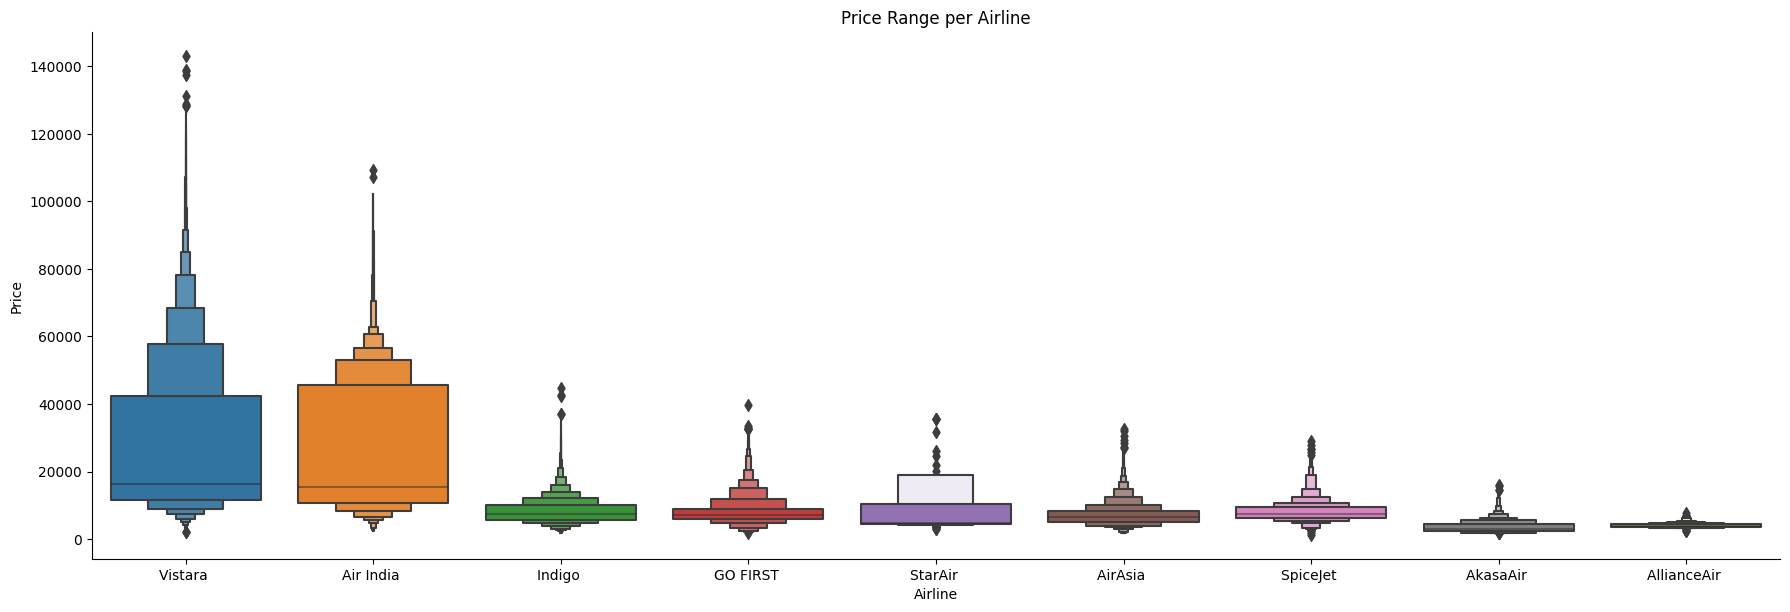

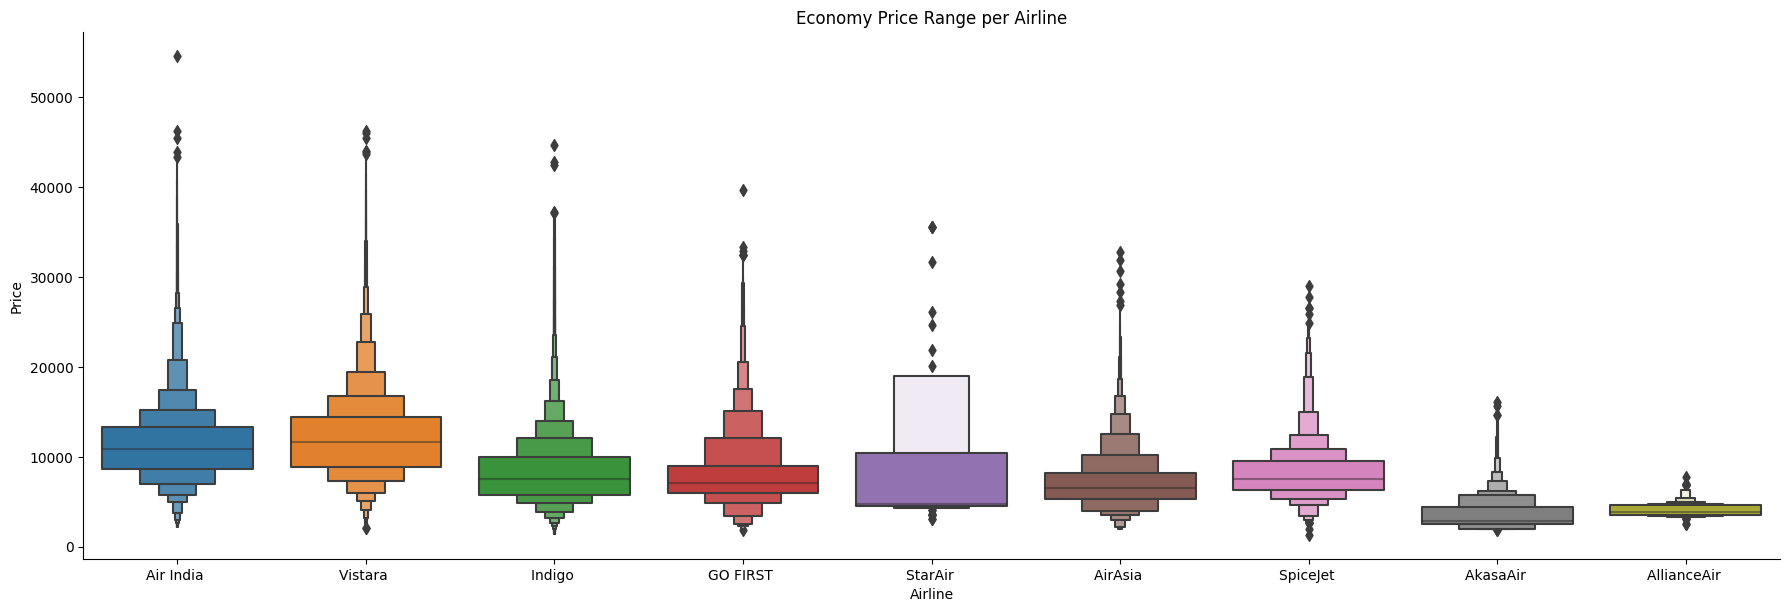

In [6]:
#Price range comparison taking into account all cabins
sns.catplot(y='Price',x='Airline',data=flightdata.sort_values("Price",ascending = False),kind = 'boxen',height =6,aspect=3)
plt.title("Price Range per Airline")
plt.show()
#And for Economy only
sns.catplot(y='Price',x='Airline',data=ec.sort_values("Price",ascending = False),kind = 'boxen',height =6,aspect=3)
plt.title("Economy Price Range per Airline")
plt.show()

In [11]:
#A quick summary of the flights by cabin
fdsummary =  flightdata.groupby(['Class', 'Airline'])['Airline'].count()
print(fdsummary)

Class           Airline     
BUSINESS        Air India       52268
                Vistara         74566
ECONOMY         Air India       67429
                AirAsia         15764
                AkasaAir         2230
                AllianceAir       393
                GO FIRST        10786
                Indigo          65659
                SpiceJet         5863
                StarAir            62
                Vistara         83847
FIRST           Air India         144
PREMIUMECONOMY  Vistara         73077
Name: Airline, dtype: int64


### Label Encoding

There are a number of features that affect the price prediction, mainly the Airline, Class, Route, Duration, Days between Booking and Travel, Day of Week and Stops. As almost all of them have a text value, these are encoded in this step to return a numeric value. This will allow for a regression model to be applied.

In [13]:
#To be able to apply a regression model, the first step is to split the data into training and test data.
#But before we split the data, we need to remove the additional cabin classes as they are not representative of all airlines.
flightdata = flightdata[flightdata['Class'] == "ECONOMY"]
#The model contains values between 16th January 2023 and 6th March 2023, which is 8 weeks.
#In order to supply enough training data, but still have enough testing data, the first 7 weeks will be used as training data.
trainingdata = flightdata[flightdata['JourneyDate']<='2023-02-27']
trainingdata.tail()
testdata = flightdata[flightdata['JourneyDate']>'2023-02-27']
testdata.head()

,JourneyDate,DaysToTravel,Airline,Flight,Class,DepartureAirport,ArrivalAirport,DepartureTime,ArrivalTime,Duration,Haul,Stops,Price
97009,2023-02-28,44,GO FIRST,G8- 364,ECONOMY,Mumbai,Delhi,17:15,00:50,455,Long Haul,1-stop,4546
97011,2023-02-28,44,Indigo,6E-6431,ECONOMY,Mumbai,Delhi,13:10,22:30,560,Long Haul,1-stop,4549
97033,2023-02-28,44,GO FIRST,G8- 329,ECONOMY,Mumbai,Delhi,05:50,08:00,130,Short Haul,non-stop,5938
97032,2023-02-28,44,SpiceJet,SG-8702,ECONOMY,Mumbai,Delhi,10:05,12:25,140,Short Haul,non-stop,5843
97031,2023-02-28,44,SpiceJet,SG-8152,ECONOMY,Mumbai,Delhi,07:10,09:30,140,Short Haul,non-stop,5843


In [14]:
#Airline Encoding
import warnings
warnings.filterwarnings('ignore')
set(trainingdata['Airline']) == set(testdata['Airline']) #ensuring they both are containing the same airlines
labelencoder = LabelEncoder() #this is to shorten the code
trainingdata['Airline'] = labelencoder.fit_transform(trainingdata['Airline'])
testdata['Airline'] = labelencoder.transform(testdata['Airline'])
#Origin Airport Encoding
set(trainingdata['DepartureAirport']) == set(testdata['DepartureAirport']) #ensuring they both are containing the same flight origins
trainingdata['DepartureAirport'] = labelencoder.fit_transform(trainingdata['DepartureAirport'])
testdata['DepartureAirport'] = labelencoder.transform(testdata['DepartureAirport'])
#Destination Airport Encoding
set(trainingdata['ArrivalAirport']) == set(testdata['ArrivalAirport']) #ensuring they both are containing the same flight destinations
trainingdata['ArrivalAirport'] = labelencoder.fit_transform(trainingdata['ArrivalAirport'])
testdata['ArrivalAirport'] = labelencoder.transform(testdata['ArrivalAirport'])
#Number of stops
#This is derived from the Stops columns in both datasets - the original column is removed in the next step
trainingdata['NumberOfStops'] = pd.np.where(trainingdata.Stops.str.contains("non-stop"), 0,
                                            pd.np.where(trainingdata.Stops.str.contains("1-stop"), 1, 2))
testdata['NumberOfStops'] = pd.np.where(testdata.Stops.str.contains("non-stop"), 0,
                                            pd.np.where(testdata.Stops.str.contains("1-stop"), 1, 2))
#Cabin Class Encoding
set(trainingdata['Class']) == set(testdata['Class']) #ensuring they both are containing the same flight destinations
trainingdata['Class'] = labelencoder.fit_transform(trainingdata['Class'])
testdata['Class'] = labelencoder.transform(testdata['Class'])
#Day of Week
trainingdata['Weekday'] = trainingdata['JourneyDate'].dt.day_name()
testdata['Weekday'] = testdata['JourneyDate'].dt.day_name()
trainingdata['Weekday'] = labelencoder.fit_transform(trainingdata['Weekday'])
testdata['Weekday'] = labelencoder.transform(testdata['Weekday'])
#Create flightsupdated as a combination
flightsupdated = trainingdata.append(testdata)

### Regression Models

In [15]:
# import the regression module
from pycaret.regression import *
# initialize setup
s = setup(data = trainingdata, test_data = testdata,
          target = 'Price', fold_strategy = 'timeseries',
          numeric_features = ['Airline', 'DepartureAirport', 'ArrivalAirport', 'Duration', 'DaysToTravel',
                             'NumberOfStops', 'Class', 'Weekday'], fold = 3,
          transform_target = True, session_id = 123)

,Description,Value
0,Session id,123
1,Target,Price
2,Target type,Regression
3,Original data shape,"(252033, 15)"
4,Transformed data shape,"(252033, 30)"
5,Transformed train set shape,"(217231, 30)"
6,Transformed test set shape,"(34802, 30)"
7,Numeric features,8
8,Date features,1
9,Categorical features,5


In [16]:
#Return the best regression model for the dataset
best = compare_models(sort = 'MSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1537.1616,6122590.9721,2290.5778,0.6546,0.2152,0.1730,66.0100
et,Extra Trees Regressor,1580.4672,6621715.3427,2382.9519,0.6263,0.2227,0.1776,49.2833
gbr,Gradient Boosting Regressor,1852.6257,6800993.3155,2527.6481,0.5962,0.2531,0.2166,21.7433
llar,Lasso Least Angle Regression,2121.1562,8276954.1806,2862.5740,0.4812,0.3028,0.2461,1.0933
knn,K Neighbors Regressor,1975.6641,8289228.8598,2739.2646,0.5194,0.2635,0.2264,43.1867
lr,Linear Regression,2192.3091,8903856.8885,2913.6235,0.4652,0.2991,0.2471,6.6700
ridge,Ridge Regression,2192.2954,8903858.7184,2913.6134,0.4652,0.2991,0.2471,2.4667
br,Bayesian Ridge,2192.2372,8904042.4312,2913.6213,0.4652,0.2991,0.2471,1.2333
huber,Huber Regressor,2209.3963,9041629.8597,2941.1279,0.4554,0.3045,0.2554,4.6367
en,Elastic Net,2286.3652,9452591.5222,3021.1390,0.4256,0.3158,0.2678,1.5100


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [17]:
prediction_holdout = predict_model(best);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,887.8105,2379737.9899,1542.6399,0.7965,0.1628,0.1045


In [18]:
# generate predictions on the original dataset
predictions = predict_model(best, data=flightsupdated)
predictions['Price'] = flightsupdated['Price']

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,410.7296,723771.9448,850.7479,0.9654,0.0780,0.0414


In [ ]:
predictions

,JourneyDate,DaysToTravel,Airline,Flight,Class,DepartureAirport,ArrivalAirport,DepartureTime,ArrivalTime,Duration,Haul,Stops,NumberOfStops,Weekday,Price,prediction_label,DayOfYear,Month,Year,Day
0,2023-01-16,1,6,SG-8169,1,3,6,20:00,22:05,125,Short Haul,non-stop,0,1,5335,5462.089909,16,1,2023,16
247754,2023-01-16,1,8,UK-894,1,4,6,20:40,20:40,1440,Long Haul,1-stop,1,1,10495,11116.097871,16,1,2023,16
247755,2023-01-16,1,8,UK-894,1,4,6,20:40,00:15,1655,Long Haul,1-stop,1,1,10545,10780.864097,16,1,2023,16
247756,2023-01-16,1,5,6E-6151,1,4,6,10:15,14:50,275,Medium Haul,1-stop,1,1,10276,10837.938292,16,1,2023,16
247757,2023-01-16,1,5,6E- 887,1,4,6,05:20,10:15,295,Medium Haul,1-stop,1,1,10377,8913.981354,16,1,2023,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59920,2023-03-06,50,0,AI-665,1,3,5,08:00,23:00,900,Long Haul,1-stop,1,1,13620,13014.615223,65,3,2023,6
59921,2023-03-06,50,0,AI-441,1,3,5,17:50,08:50,900,Long Haul,1-stop,1,1,13620,12654.982529,65,3,2023,6
59922,2023-03-06,50,0,AI-665,1,3,5,08:00,23:50,950,Long Haul,1-stop,1,1,13620,12267.839796,65,3,2023,6
59916,2023-03-06,50,0,AI-865,1,3,5,10:00,23:50,830,Long Haul,1-stop,1,1,13620,12255.000000,65,3,2023,6


In [21]:
#Line plot of the averages
ecpredbydate = predictions.groupby('JourneyDate').agg({'Price': 'mean', 'prediction_label': 'mean', 'Airline': 'mean', 'DepartureAirport': 'mean',
                                                  'ArrivalAirport': 'mean', 'Duration': 'mean', 'NumberOfStops': 'mean'})
ecpredbydate = ecpredbydate.reset_index()
fig = px.line(ecpredbydate, x='JourneyDate', y=["Price",'prediction_label'], template = 'plotly_dark')
#Add a vertical rectange to show where test-set separation was
TestStartDate = testdata['JourneyDate'].min()
TestEndDate = testdata['JourneyDate'].max()
fig.add_vrect(x0=TestStartDate , x1=TestEndDate, fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

In [23]:
#Evaluating the model
final_best = finalize_model(best)
evaluate_model(final_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Forecasting

In [25]:
#Create forecast dataframe for 2 weeks of forecast
ForecastStartDate = TestEndDate + datetime.timedelta(days = 1)
ForecastEndDate = TestEndDate + datetime.timedelta(days = 14)
forecastflights = pd.DataFrame(pd.date_range(start=ForecastStartDate, end=ForecastEndDate), columns=['JourneyDate'])
forecastflights['Class'] = 1
forecastflights['Airline'] = ecpredbydate['Airline'].mean()
forecastflights['BookingDate'] = pd.to_datetime('2023-01-15')
forecastflights['DaysToTravel'] = forecastflights.apply(lambda row: (row['JourneyDate'] - row['BookingDate']).days, axis=1)
forecastflights['Flight'] = 'NaN'
forecastflights['DepartureAirport'] = ecpredbydate['DepartureAirport'].mean()
forecastflights['ArrivalAirport'] = ecpredbydate['ArrivalAirport'].mean()
forecastflights['DepartureTime'] = 'NaN'
forecastflights['ArrivalTime'] = 'NaN'
forecastflights['Duration'] = ecpredbydate['Duration'].mean()
forecastflights['Haul'] = 'NaN'
forecastflights['Stops'] = 'NaN'
forecastflights['NumberOfStops'] = ecpredbydate['NumberOfStops'].mean()
forecastflights['Weekday'] = forecastflights['JourneyDate'].dt.day_name()
forecastflights['Weekday'] = labelencoder.transform(forecastflights['Weekday'])
forecastflights = forecastflights.drop(columns='BookingDate')
forecastflights.tail()

,JourneyDate,Class,Airline,DaysToTravel,Flight,DepartureAirport,ArrivalAirport,DepartureTime,ArrivalTime,Duration,Haul,Stops,NumberOfStops,Weekday
9,2023-03-16,1,4.361805,60,NaN,3.158084,3.188123,NaN,NaN,661.625706,NaN,NaN,0.932021,4
10,2023-03-17,1,4.361805,61,NaN,3.158084,3.188123,NaN,NaN,661.625706,NaN,NaN,0.932021,0
11,2023-03-18,1,4.361805,62,NaN,3.158084,3.188123,NaN,NaN,661.625706,NaN,NaN,0.932021,2
12,2023-03-19,1,4.361805,63,NaN,3.158084,3.188123,NaN,NaN,661.625706,NaN,NaN,0.932021,3
13,2023-03-20,1,4.361805,64,NaN,3.158084,3.188123,NaN,NaN,661.625706,NaN,NaN,0.932021,1


In [26]:
predictions_future = predict_model(final_best, data=forecastflights)
predictions_future.tail()

,JourneyDate,Class,Airline,DaysToTravel,Flight,DepartureAirport,ArrivalAirport,DepartureTime,ArrivalTime,Duration,Haul,Stops,NumberOfStops,Weekday,prediction_label
9,2023-03-16,1,4.361805,60,NaN,3.158083,3.188123,NaN,NaN,661.625732,NaN,NaN,0.932021,4,8712.011900
10,2023-03-17,1,4.361805,61,NaN,3.158083,3.188123,NaN,NaN,661.625732,NaN,NaN,0.932021,0,8806.748040
11,2023-03-18,1,4.361805,62,NaN,3.158083,3.188123,NaN,NaN,661.625732,NaN,NaN,0.932021,2,8864.142187
12,2023-03-19,1,4.361805,63,NaN,3.158083,3.188123,NaN,NaN,661.625732,NaN,NaN,0.932021,3,8841.975114
13,2023-03-20,1,4.361805,64,NaN,3.158083,3.188123,NaN,NaN,661.625732,NaN,NaN,0.932021,1,8868.943515


In [31]:
#Show predictions
concatflights = pd.concat([flightsupdated,predictions_future], axis=0)
concatflights = concatflights.groupby('JourneyDate').agg({'Price': 'mean', 'prediction_label': 'mean', 'Airline': 'mean', 'DepartureAirport': 'mean',
                                                  'ArrivalAirport': 'mean', 'Duration': 'mean', 'NumberOfStops': 'mean'})
concatflights = concatflights.reset_index()
fig = px.line(concatflights, x='JourneyDate', y=["Price", "prediction_label"], template = 'plotly_dark')
fig.show()